## Сегментация опухолей мозга с помощью UNet

<img src="https://i.imgur.com/Q8oI4M6.png" 
     align="right" 
     width="300"
     style="padding: 20px;" />

Цель домашней работы - обучить [UNet](https://arxiv.org/abs/1505.04597) для сегментации опухолей головного мозга



### Загрузка данных
Данные представлены в виде питоновского словаря, где пары изображение-маска сохранены как .h5 файл, с ключами `image` и `mask`.

Датасет доступен по [ссылке](https://disk.yandex.ru/d/D_x_9woD55P8_g)

In [12]:
import numpy as np
import os
import h5py

# Directory containing .h5 files
path_to_data = 'data/'  # Change it accordingly 
directory = f'{path_to_data}BraTS2020_training_data/content/data'

# Create a list of all .h5 files in the directory
h5_files = [f for f in os.listdir(directory) if f.endswith('.h5')]
print(f"Found {len(h5_files)} .h5 files:\nExample file names:{h5_files[:3]}")

# Open the first .h5 file in the list to inspect its contents
if h5_files:
    file_path = os.path.join(directory, h5_files[25070])
    with h5py.File(file_path, 'r') as file:
        print("\nKeys for each file:", list(file.keys()))
        for key in file.keys():
            print(f"\nData type of {key}:", type(file[key][()]))
            print(f"Shape of {key}:", file[key].shape)
            print(f"Array dtype: {file[key].dtype}")
            print(f"Array max val: {np.max(file[key])}")
            print(f"Array min val: {np.min(file[key])}")
else:
    print("No .h5 files found in the directory.")

Found 57195 .h5 files:
Example file names:['volume_69_slice_63.h5', 'volume_224_slice_69.h5', 'volume_277_slice_16.h5']

Keys for each file: ['image', 'mask']

Data type of image: <class 'numpy.ndarray'>
Shape of image: (240, 240, 4)
Array dtype: float64
Array max val: 4.880554924163209
Array min val: -0.5346303106398443

Data type of mask: <class 'numpy.ndarray'>
Shape of mask: (240, 240, 3)
Array dtype: uint8
Array max val: 1
Array min val: 0


## О данных
Our dataset consists of images from brain scans, as well as masked labels indicating regions of abnormal tissue. Each image has 4 channels.

#### Image channels:
1) **T1-weighted (T1)**: This sequence produces a high resolution image of the brain's anatomy. It's good for visualising the structure of the brain but not as sensitive to tumour tissue as other sequences.

2) **T1-weighted post contrast (T1c or T1Gd)**: After the injection of a contrast agent (usually gadolinium), T1-weighted images are taken again. The contrast agent enhances areas with a high degree of vascularity and blood-brain barrier breakdown, which is typical in tumour tissue, making this sequence particularly useful for highlighting malignant tumours.

3) **T2-weighted (T2)**: T2 images provide excellent contrast of the brain's fluid spaces and are sensitive to edema (swelling), which often surrounds tumours. It helps in visualizing both the tumour and changes in nearby tissue.

4) **Fluid Attenuated Inversion Recovery (FLAIR)**: This sequence suppresses the fluid signal, making it easier to see peritumoral edema (swelling around the tumour) and differentiate it from the cerebrospinal fluid. It's particularly useful for identifying lesions near or within the ventricles.

Regarding the masks, they represent segmentations, containing areas of interest within the brain scans, specifically focusing on abnormal tissue related to brain tumours. We will use these masks for training models in segmenting brain tumours from normal brain tissue. Each mask has 3 channels.

#### Mask channels
1) **Necrotic and Non-Enhancing Tumour Core (NCR/NET)**: This masks out the necrotic (dead) part of the tumour, which doesn't enhance with contrast agent, and the non-enhancing tumour core.

2) **Edema (ED)**: This channel masks out the edema, the swelling or accumulation of fluid around the tumour.

3) **Enhancing Tumour (ET)**: This masks out the enhancing tumour, which is the region of the tumour that shows uptake of contrast material and is often considered the most aggressive part of the tumour.

### Viewing Sample Images
We'll use matplotlib imshow to view some example brain scans, and see the tumour locations.

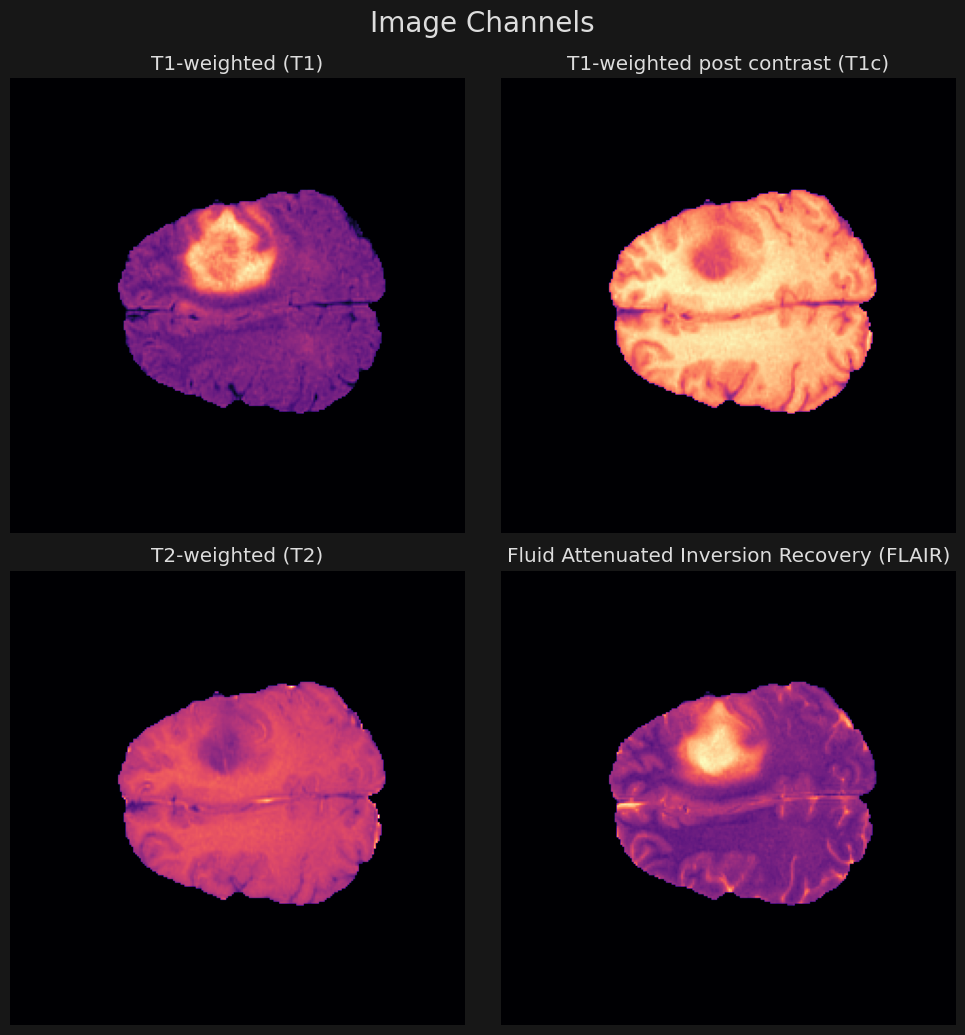

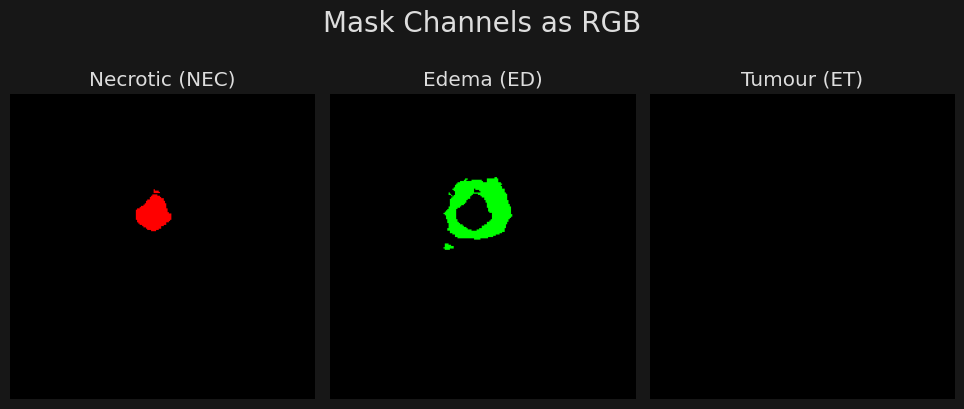

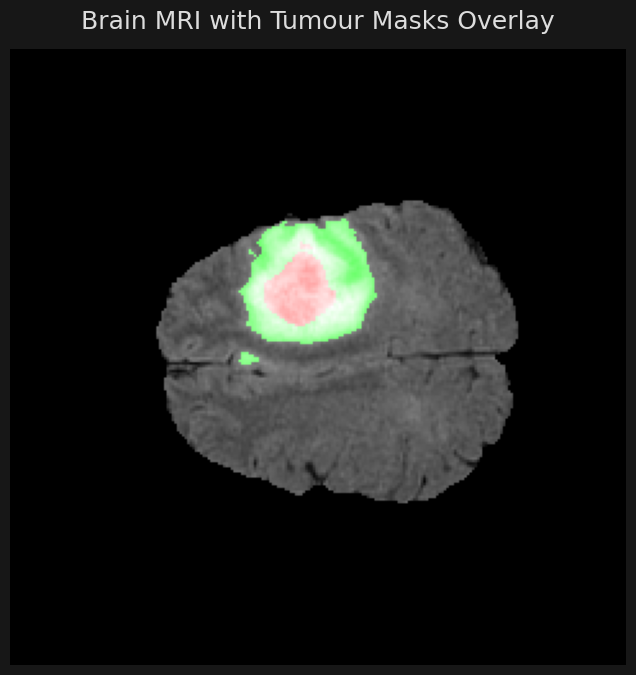

In [14]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.facecolor'] = '#171717'
plt.rcParams['text.color']       = '#DDDDDD'

def display_image_channels(image, title='Image Channels'):
    channel_names = ['T1-weighted (T1)', 'T1-weighted post contrast (T1c)', 'T2-weighted (T2)', 'Fluid Attenuated Inversion Recovery (FLAIR)']
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    for idx, ax in enumerate(axes.flatten()):
        channel_image = image[idx, :, :]  # Transpose the array to display the channel
        ax.imshow(channel_image, cmap='magma')
        ax.axis('off')
        ax.set_title(channel_names[idx])
    plt.tight_layout()
    plt.suptitle(title, fontsize=20, y=1.03)
    plt.show()

def display_mask_channels_as_rgb(mask, title='Mask Channels as RGB'):
    channel_names = ['Necrotic (NEC)', 'Edema (ED)', 'Tumour (ET)']
    fig, axes = plt.subplots(1, 3, figsize=(9.75, 5))
    for idx, ax in enumerate(axes):
        rgb_mask = np.zeros((mask.shape[1], mask.shape[2], 3), dtype=np.uint8)
        rgb_mask[..., idx] = mask[idx, :, :] * 255  # Transpose the array to display the channel
        ax.imshow(rgb_mask)
        ax.axis('off')
        ax.set_title(channel_names[idx])
    plt.suptitle(title, fontsize=20, y=0.93)
    plt.tight_layout()
    plt.show()

def overlay_masks_on_image(image, mask, title='Brain MRI with Tumour Masks Overlay'):
    t1_image = image[0, :, :]  # Use the first channel of the image
    t1_image_normalized = (t1_image - t1_image.min()) / (t1_image.max() - t1_image.min())

    rgb_image = np.stack([t1_image_normalized] * 3, axis=-1)
    color_mask = np.stack([mask[0, :, :], mask[1, :, :], mask[2, :, :]], axis=-1)
    rgb_image = np.where(color_mask, color_mask, rgb_image)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(rgb_image)
    plt.title(title, fontsize=18, y=1.02)
    plt.axis('off')
    plt.show()
    
    
# Sample image to view
sample_file_path = os.path.join(directory, h5_files[25070])
data = {}
with h5py.File(sample_file_path, 'r') as file:
    for key in file.keys():
        data[key] = file[key][()]

# Transpose the image and mask to have channels first
image = data['image'].transpose(2, 0, 1)
mask = data['mask'].transpose(2, 0, 1)

# View images using plotting functions
display_image_channels(image)
display_mask_channels_as_rgb(mask)
overlay_masks_on_image(image, mask)

### Создаем Dataset и DataLoader
Наш датасет относительно большой - ~8GB, поэтому возпользуемся dataloader для загрузки пар данных батчами. Посколько данные формат данных нестандартный, нам нужно написать свой собственный Dataset object и DataLoader. 

Изображения сохранены в формате `float64` с интенсивностью пикселя от ~-0.5 до ~230 и `height`, `width`, `channels` последовательностью каналов. Маски сохраннены в `uint8` и пиксели там представлены 0 и 1. 

Наш Dataset должен загрузить изображение, зарешейпить его в  `channels`, `height`, `width`, поправить значения пикселей чтобы минимум был в 0 на каждом изображении, затем каждый канал, чтобы максимум был 1, затем сконвертировать в  `torch.float32` tensor.

### 2 points

In [15]:
import torch
from torch.utils.data import Dataset, DataLoader

class BrainScanDataset(Dataset):
    def __init__(self, file_paths, deterministic=False):
        self.file_paths = file_paths
        if deterministic:  # To always generate the same test images for consistency
            np.random.seed(1)
        np.random.shuffle(self.file_paths)
        
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        # Load h5 file, get image and mask
        file_path = self.file_paths[idx]
        with h5py.File(file_path, 'r') as file:
            image = file['image'][()]
            mask = file['mask'][()]
            
            # Reshape: (H, W, C) -> (C, H, W)
            image =  # YOUR CODE HERE # 
            mask =  # YOUR CODE HERE # 
            
            # Adjusting pixel values for each channel in the image so they are between 0 and 255
            for i in range(image.shape[0]):    # Iterate over channels
                # YOUR CODE HERE #
            
            image = torch.tensor(image, dtype=torch.float32)
            mask = torch.tensor(mask, dtype=torch.float32) 
            
        return image, mask

# Build .h5 file paths from directory containing .h5 files
h5_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.h5')]
np.random.seed(42)
np.random.shuffle(h5_files)

# Split the dataset into train and validation sets (90:10)
split_idx = int(0.9 * len(h5_files))
train_files = h5_files[:split_idx]
val_files = h5_files[split_idx:]

# Create the train and val datasets
train_dataset = BrainScanDataset(train_files)
val_dataset = BrainScanDataset(val_files, deterministic=True)

# Sample dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=5, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=5, shuffle=False)

# Use this to generate test images to view later
test_input_iterator = iter(DataLoader(val_dataset, batch_size=1, shuffle=False))

# Verifying dataloaders work
for images, masks in train_dataloader:
    print("Training batch - Images shape:", images.shape, "Masks shape:", masks.shape)
    assert images.shape == torch.Size([5, 4, 240, 240])
    assert masks.shape == torch.Size([5, 3, 240, 240])
    break
for images, masks in val_dataloader:
    print("Validation batch - Images shape:", images.shape, "Masks shape:", masks.shape)
    break

Training batch - Images shape: torch.Size([5, 4, 240, 240]) Masks shape: torch.Size([5, 3, 240, 240])
Validation batch - Images shape: torch.Size([5, 4, 240, 240]) Masks shape: torch.Size([5, 3, 240, 240])


## The UNet Architecture

<img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png" 
     align="right" 
     width="500"
     style="padding: 20px;" />
     
[UNet](https://arxiv.org/abs/1505.04597) is a deep learning neural network architecture originally designed for image segmentation tasks, but has since found use in GANs and latent diffusion models. Similar to autoencoders, the UNet structures include an encoder for compressing the input into a lower dimensional representation and a decoder for reconstructing the output from this compressed form. However, UNet distinguishes itself from autoencoders with several features:

- **Bottleneck**: At the centre of UNet is the bottleneck layer, situated between the encoder and decoder. This component captures the most abstract representation of the input.

- **Symmetrical Design**: The encoder and decoder parts of UNet are mirror images of each other. This symmetry facilitates the implementation of skip connections, which directly connect layers of the encoder to their corresponding layers in the decoder.

- **Skip Connections**: Unlike conventional autoencoders, UNet incorporates skip connections that can bypass the bottleneck, directly connecting the encoder to the decoder. These connections transfer contextual information from the spatially rich encoder, to the more feature heavy decoder, aiding in the precise localisation necessary for detailed segmentation.

In this project we're going to start off with the original UNet architecture, then work on building in some staple CV tweaks like separable convolution layers, batch norm, fewer activation functions, additive skip connections, larger kernels, then finally include the attention mechanism from [Attention UNet](https://arxiv.org/abs/1804.03999).

### 4 points

Мы с вами писали UNet на семинаре, здесь нужно сделать то же самое - можно как перенсти архитектуру оттуда, либо дополнить скелетный код, который дан ниже. Можно и полностью переписать весь код здесь, сохранив лишь его верхнеуровневую структуру - класс для энкодера и декодера блоков, класс для модели.

Глубину можно менять по своему вкусу, но рекомендую не менее 3х слоев в глубину.

In [4]:
from torch import nn

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.ReLU()):
        super().__init__()
        self.encoder_block = nn.Sequential(
             # Conv2d # ,
            activation,
             # Conv2d # ,
            activation
        )
    def forward(self, x):
        return  # YOUR CODE HERE # 
    
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.ReLU()):
        super().__init__()
        self.decoder_block = nn.Sequential(
             # Conv2d # ,
            activation,
             # Conv2d # ,
            activation
        )
    def forward(self, x):
        return  # YOUR CODE HERE # 

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Config
        in_channels  = 4   # Input images have 4 channels
        out_channels = 3   # Mask has 3 channels
        n_filters    = 32  # Scaled down from 64 in original paper
        activation   = nn.ReLU()
        
        # Up and downsampling methods
        self.downsample  =  # YOUR CODE HERE # 
        self.upsample    = nn.UpsamplingBilinear2d(scale_factor=2)
        
        # Encoder
        self.enc_block_1 =  # YOUR CODE HERE # 
        self.enc_block_2 =  # YOUR CODE HERE # 
        self.enc_block_3 =  # YOUR CODE HERE # 
        self.enc_block_4 =  # YOUR CODE HERE #    ### YOU CAN CHANGE THE DEPTH OF UNET ###
        
        # Bottleneck
        self.bottleneck  = nn.Sequential(
             # YOUR CODE HERE # ,
            activation,
             # YOUR CODE HERE # ,
            activation
        )
        
        # Decoder
        self.dec_block_4 =  # YOUR CODE HERE # 
        self.dec_block_3 =  # YOUR CODE HERE # 
        self.dec_block_2 =  # YOUR CODE HERE # 
        self.dec_block_1 =  # YOUR CODE HERE # 
        
        # Output projection
        self.output      = nn.Conv2d(1*n_filters,  out_channels, kernel_size=(1,1), stride=1, padding=0)

        
    def forward(self, x):
        # Encoder
         # YOUR CODE HERE # 
            # REMEMBER: 4 skip_connections
            
         # YOUR CODE HERE # 
        
        # Bottleneck
        x      = self.bottleneck(x)
        
        # Decoder
         # YOUR CODE HERE # 
         # DO NOT FORGET ABOUT skip_connections
         # YOUR CODE HERE # 
        return x
    
# Function to count number of parameters in a model for comparisons later
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    print(f'Total Parameters: {total_params:,}\n')

# Function that saves a model to specified path
def save_model(model, path='model_weights.pth'):
    torch.save(model.state_dict(), path)

### Training Loop


### 4 points

In [5]:
# YOU CAN REWRITE THIS ENTIRE BLOCK

def train_model(model, train_dataloader, val_dataloader, verbose=True):
    device =  # YOUR CODE HERE # 
    n_epochs =  # YOUR CODE HERE # 
    learning_rate =  # YOUR CODE HERE # 
    batches_per_epoch =  # YOUR CODE HERE # You can reduce the amount of computing with that
    lr_decay_factor =  # YOUR CODE HERE # 

    model.to(device)
    optimizer =  # YOUR CODE HERE # 
    loss_fn = nn.BCEWithLogitsLoss()

    train_epoch_losses = []
    val_epoch_losses = []
    
    print("Training...")
    for epoch in range(1, n_epochs + 1):\
        
        # Decay learning rate. Make it smaller with each epoch
        current_lr =  # YOUR CODE HERE # Or you can leave it with learning_rate, thus disabling decaying
        
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_lr

        # Training step
        model.train()
        train_epoch_loss = 0
        for train_batch_idx, (train_inputs, train_targets) in enumerate(train_dataloader, start=1):
            if verbose: print(f"\rTrain batch: {train_batch_idx}/{batches_per_epoch}, Avg batch loss: {train_epoch_loss/train_batch_idx:.6f}", end='')
            train_inputs =  # YOUR CODE HERE # 
            train_targets =  # YOUR CODE HERE # 
            train_preds =  # YOUR CODE HERE # 
            train_batch_loss =  # YOUR CODE HERE # 
            train_epoch_loss +=  # YOUR CODE HERE # 

             # YOUR CODE HERE # 
                ## something important here ##
             # YOUR CODE HERE # 

            # FEEL FREE TO UNCOMMENT NEXT LINE TO REDUCE COMPUTATION.
#             if train_batch_idx >= batches_per_epoch:   # if you want lesser batches amount per epoch 
#                 if verbose: print()
#                 break
        train_epoch_losses.append(train_epoch_loss)

        # Val step
         # YOUR CODE HERE # 
         # YOUR CODE HERE # 
         # YOUR CODE HERE # 
        val_epoch_losses.append(val_epoch_loss)

        if verbose: print(f"Epoch: {epoch}, Train loss: {train_epoch_loss:.6f}, Val loss: {val_epoch_loss:.6f}, lr {current_lr:.6f}\n")
        
    print("Training complete.")
    return train_epoch_losses, val_epoch_losses

In [ ]:
# YOU CAN HAVE A DICT WITH TRAING PARAMS AS EXPERIMENT CONFIG

# Create UNet model and count params
model = UNet()
count_parameters(model)   # I had 5,496,451 params

# Create dataloaders

# Train model
train_epoch_losses, val_epoch_losses = train_model(model, train_dataloader, val_dataloader, verbose=False)

### Смотрим на результат
Здесь ничего менять не надо

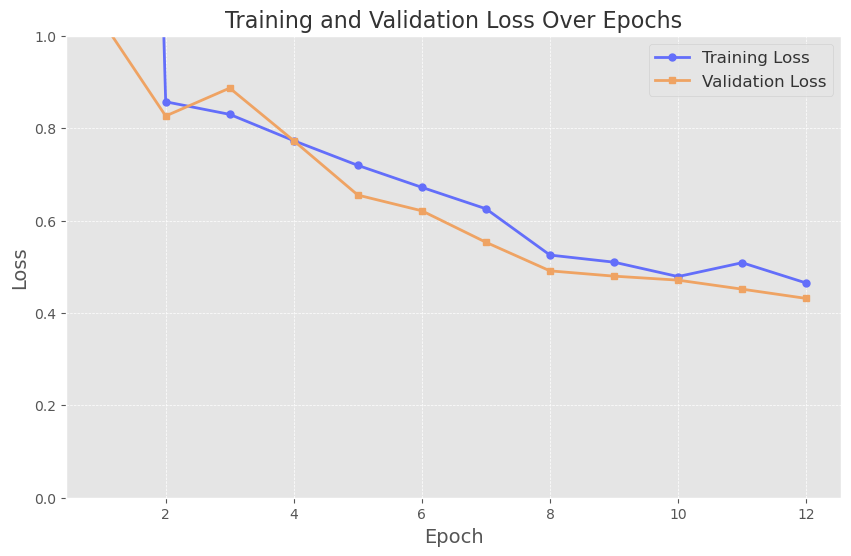

In [7]:
def plot_learning_curves(train_epoch_losses, val_epoch_losses):
    plt.style.use('ggplot')
    plt.rcParams['text.color'] = '#333333'

    fig, axis = plt.subplots(1, 1, figsize=(10, 6))

    # Plot training and validation loss (NaN is used to offset epochs by 1)
    axis.plot([np.NaN] + train_epoch_losses, color='#636EFA', marker='o', linestyle='-', linewidth=2, markersize=5, label='Training Loss')
    axis.plot([np.NaN] + val_epoch_losses,   color='#EFA363', marker='s', linestyle='-', linewidth=2, markersize=5, label='Validation Loss')

    # Adding title, labels and formatting
    axis.set_title('Training and Validation Loss Over Epochs', fontsize=16)
    axis.set_xlabel('Epoch', fontsize=14)
    axis.set_ylabel('Loss', fontsize=14)

    axis.set_ylim(0, 1)
    
    axis.legend(fontsize=12)
    axis.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()
    
plot_learning_curves(train_epoch_losses, val_epoch_losses)

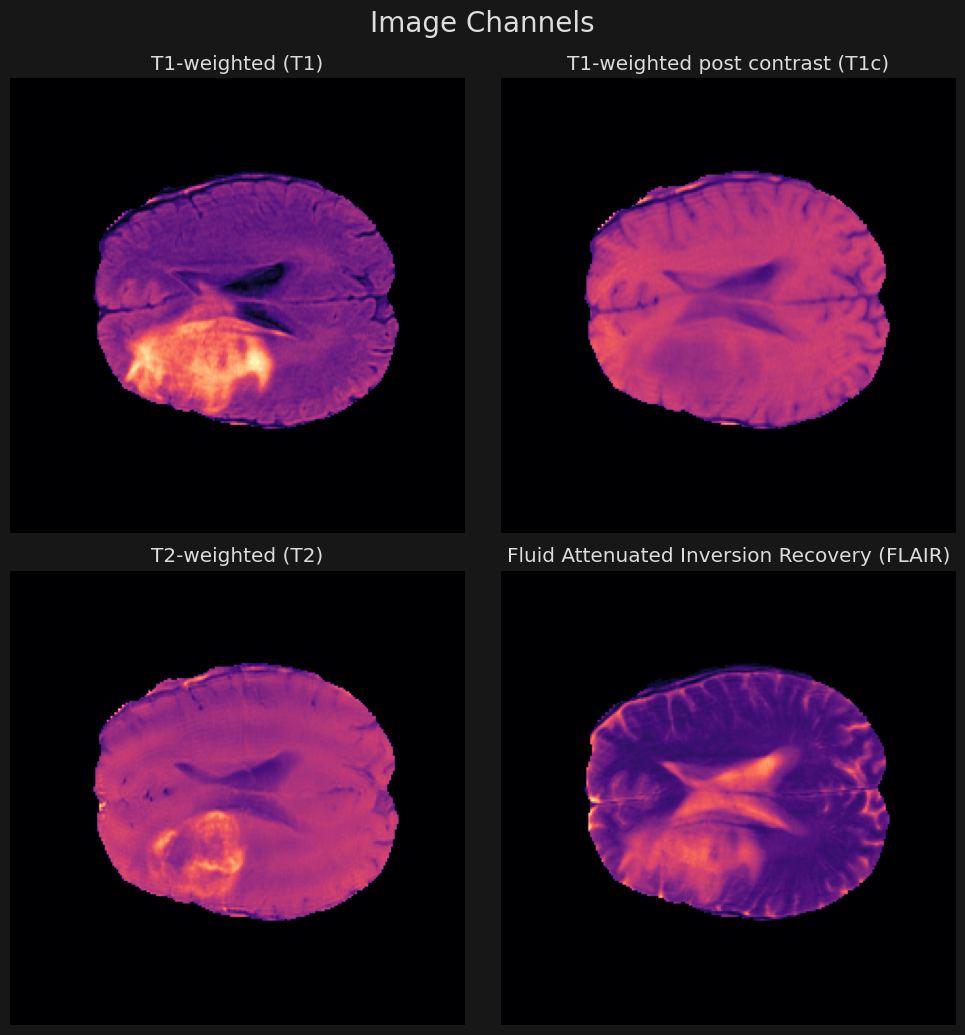

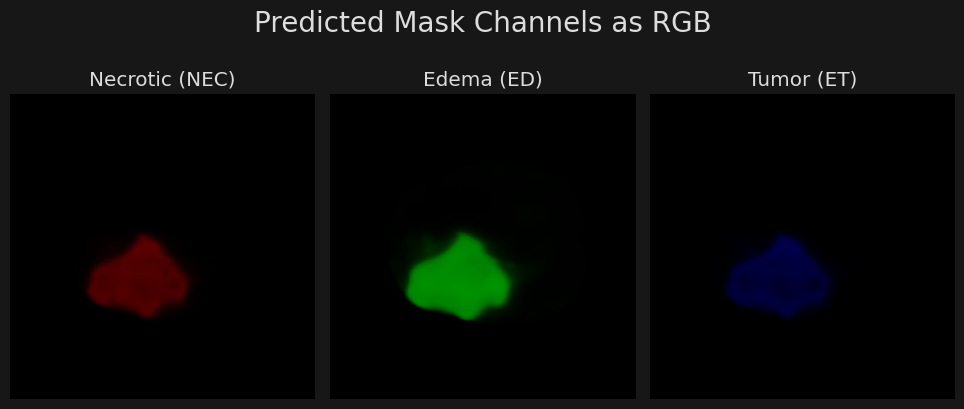

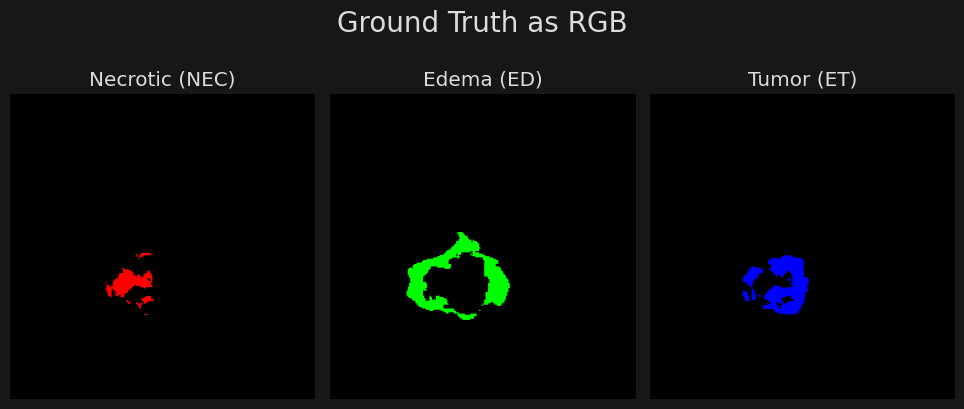

In [8]:
def display_test_sample(model, test_input, test_target, device):
    test_input, test_target = test_input.to(device), test_target.to(device)

    # Obtain the model's prediction
    test_pred = torch.sigmoid(model(test_input))

    # Process the image and masks for visualization
    image = test_input.detach().cpu().numpy().squeeze(0)
    mask_pred = test_pred.detach().cpu().numpy().squeeze(0)
    mask_target = test_target.detach().cpu().numpy().squeeze(0)

    # Set the plot aesthetics
    plt.rcParams['figure.facecolor'] = '#171717'
    plt.rcParams['text.color']       = '#DDDDDD'

    # Display the input image, predicted mask, and target mask
    display_image_channels(image)
    display_mask_channels_as_rgb(mask_pred, title='Predicted Mask Channels as RGB')
    display_mask_channels_as_rgb(mask_target, title='Ground Truth as RGB')
    

# Set so model and these images are on the same device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
# Get an image from the validation dataset that the model hasn't been trained on
test_input, test_target = next(test_input_iterator)

display_test_sample(model, test_input, test_target, device)